In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import LinearSVR

In [3]:
data = pd.read_csv('train.csv')

Обработаем данные 

Заполним пропущенные значения этих переменных строкой None

In [4]:
data.Alley.fillna('None', inplace = True)
data.MasVnrType.fillna('None', inplace = True)
data.MasVnrArea.fillna(0.0, inplace = True)
data.BsmtQual.fillna('None', inplace = True)
data.BsmtCond.fillna('None', inplace = True)
data.GarageType.fillna('None', inplace = True)
data.BsmtExposure.fillna('None', inplace = True)
data.BsmtFinType1.fillna('None', inplace = True)
data.BsmtFinType2.fillna('None', inplace = True)
data.FireplaceQu.fillna('None', inplace = True)
data.GarageFinish.fillna('None', inplace = True)
data.GarageQual.fillna('None', inplace = True)
data.GarageCond.fillna('None', inplace = True)
data.PoolQC.fillna('None', inplace = True)
data.Fence.fillna('None', inplace = True)
data.MiscFeature.fillna('None', inplace = True)

Для этих параметров сделаем другую обработку

In [5]:
#Единственное пропущенное значение Electrical заменим на самое повторяющееся
data.Electrical.fillna('SBrkr', inplace = True)
#пропущенные значения LotFrontage заменим на среднее
data.LotFrontage.fillna(round(data.LotFrontage.mean(),0), inplace = True)
# Пропущенные значения GarageYrBlt заменим на значения YearBuilt, так как в большинстве других значений они равны
data.loc[data.GarageYrBlt.isnull(), 'GarageYrBlt'] = data.YearBuilt

In [ ]:
data.info()

Теперь для этих фичей сделаем LabelEncoding

In [6]:
Columns = ['MSZoning', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
       'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition', 'Electrical']

In [7]:
le = LabelEncoder()
for column in Columns:
    le.fit(data[column])
    data[column] = le.transform(data[column])

**Part 1. Построить случайный лес, вывести важность признаков

Подготовим данные для регрессии

In [8]:
x = data.copy()
x.drop(['Id', 'SalePrice'], axis=1, inplace=True)
y = data.SalePrice

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [10]:
model =  RandomForestRegressor(n_estimators=10, max_depth=5, n_jobs=-1)

In [11]:
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [12]:
y_pred = model.predict(x_test)

In [13]:
print(f'Score : {model.score(x_test, y_test)}')


Score : 0.7394195625395583


** Part 2. вывести важность признаков

<function matplotlib.pyplot.show(*args, **kw)>

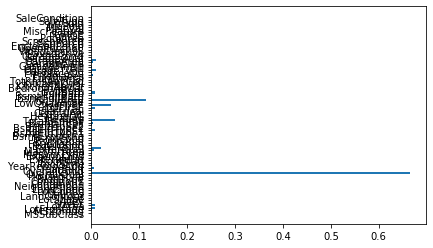

In [14]:
plt.barh(np.arange(len(model.feature_importances_)), model.feature_importances_)
plt.yticks(np.arange(len(x.columns)),x.columns)
plt.show

Поищем лучшие параметры модели

In [39]:
params = {'max_depth': range(2,9),
          'n_estimators': (10, 50, 100),
          'criterion': ('mse', 'mae')}

In [40]:
gsc = GridSearchCV(estimator=RandomForestRegressor(), 
                   param_grid=params, cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
grid_result = gsc.fit(x_train, y_train)
best_params = grid_result.best_params_
    
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], 
                            n_estimators=best_params["n_estimators"], random_state=False, verbose=False)

In [42]:
rfr.fit(x_train, y_train)
rfr.score(x_test, y_test)

0.7500338411838335

In [41]:
best_params

{'criterion': 'mse', 'max_depth': 8, 'n_estimators': 50}

** Part 2. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

Model 1

In [55]:
estimators1 = [('lr', LinearRegression()), 
              ('rfr', RandomForestRegressor(max_depth=best_params["max_depth"], 
                                            n_estimators=best_params["n_estimators"], 
                                            criterion=best_params["criterion"], 
                                            random_state=42, 
                                            verbose=0, 
                                            n_jobs=-1
                                           ))
             ]

reg1 = StackingRegressor(estimators=estimators1,
                        final_estimator=LinearRegression()
                       )

In [56]:
reg1.fit(x_train, y_train)
reg1.score(x_test, y_test)

0.7028343301267639

Model 2

In [47]:
estimators2 = [('ridge', RidgeCV()), 
              ('svr', LinearSVR(random_state=42))
             ]

reg2 = StackingRegressor(estimators=estimators2,
                        final_estimator=RandomForestRegressor(max_depth=best_params["max_depth"], 
                            n_estimators=best_params["n_estimators"], random_state=42, verbose=False)
                       )

In [48]:
reg2.fit(x_train, y_train)
reg2.score(x_test, y_test)

C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

0.6818909011003366

Model 3

In [49]:
estimators3 = [('ridge', RidgeCV()), 
              ('dtr', DecisionTreeRegressor())
             ]

reg3 = StackingRegressor(estimators=estimators3,
                        final_estimator=RandomForestRegressor(max_depth=best_params["max_depth"], 
                            n_estimators=best_params["n_estimators"], random_state=42, verbose=False)
                       )

In [50]:
reg3.fit(x_train, y_train)
reg3.score(x_test, y_test)

0.7549549004716429